In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from librosa.filters import mel as librosa_mel_fn
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import pickle
import csv
import sys, wave

torch.manual_seed(0);
gpu_boole = torch.cuda.is_available()

## GETTING DATA:

In [36]:
AUDIO_LENGTH = 5000
OUTPUT_DIR = './drive/MyDrive/DL_FINAL_PROJECT/output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')

train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.csv'))

In [ ]:
# shows the sound waves
def visualize_wav(path: str):
   
    # reading the audio file
    raw = wave.open(path)
     
    # reads all the frames
    # -1 indicates all or max frames
    signal = raw.readframes(-1)
    signal = np.frombuffer(signal, dtype ="int16")
     
    # gets the frame rate
    f_rate = raw.getframerate()
 
    # to Plot the x-axis in seconds
    # you need get the frame rate
    # and divide by size of your signal
    # to create a Time Vector
    # spaced linearly with the size
    # of the audio file
    time = np.linspace(
        0, # start
        len(signal) / f_rate,
        num = len(signal)
    )
 
    # using matplotlib to plot
    # creates a new figure
    plt.figure(1)
     
    # title of the plot
    plt.title("Sound Wave")
     
    # label of x-axis
    plt.xlabel("Time")
    
    # actual plotting
    plt.plot(time, signal)
     
    # shows the plot
    # in new window
    plt.show()

In [37]:
def get_data(file_list):
    def load_into(_filename, _x):
        with open(_filename, 'rb') as f:
            audio_element = np.loadtxt(f, delimiter=",")
            audio_element = audio_element.reshape(1,5000)
            _x.append(audio_element)
    x = []
    count = 0
    for filename in file_list:
        if count < 10:
            load_into(filename, x)
        else:
            break
        #count += 1
        
    return np.array(x)

In [38]:
train_data = get_data(train_files)
print(train_data.shape)

(782, 1, 5000)


In [39]:
class Audio2Mel(nn.Module):
    def __init__(
        self,
        n_fft=1024,
        hop_length=256,
        win_length=1024,
        sampling_rate=22050,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=None,
    ):
        super().__init__()
        ##############################################
        # FFT Parameters                              #
        ##############################################
        window = torch.hann_window(win_length).float()
        mel_basis = librosa_mel_fn(
            sampling_rate, n_fft, n_mel_channels, mel_fmin, mel_fmax
        )
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer("mel_basis", mel_basis)
        self.register_buffer("window", window)
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.sampling_rate = sampling_rate
        self.n_mel_channels = n_mel_channels

    def forward(self, audio):
        p = (self.n_fft - self.hop_length) // 2
        audio = F.pad(audio, (p, p), "reflect").squeeze(1)
        fft = torch.stft(
            audio,
            n_fft=self.n_fft,
            hop_length=self.hop_length,
            win_length=self.win_length,
            window=self.window,
            center=False,
        )
        real_part, imag_part = fft.unbind(-1)
        magnitude = torch.sqrt(real_part ** 2 + imag_part ** 2)
        mel_output = torch.matmul(self.mel_basis, magnitude)
        log_mel_spec = torch.log10(torch.clamp(mel_output, min=1e-5))
        return log_mel_spec

## CREATING ARCHITECTURE:

In [40]:
class generator(nn.Module):
    # initializers
    def __init__(self, input_channel):
        super(generator, self).__init__()
        #TODO
        self.reflPad1 = nn.ReflectionPad1d((3,3))
        self.conv1 = nn.Conv1d(input_channel, 1024, kernel_size=1, stride=1)
        self.dropout1 = nn.Dropout()
        self.act1 = nn.LeakyReLU(0.2)
        
        self.convTrans1 = nn.ConvTranspose1d(1024,512, kernel_size=81, stride=16, padding=4)
        self.act2 = nn.LeakyReLU(0.2)
        
        self.convTrans2 = nn.ConvTranspose1d(512,256, kernel_size=48, stride=8, padding=4)
        self.act3 = nn.LeakyReLU(0.2)
        
        self.convTrans3 = nn.ConvTranspose1d(256,128, kernel_size=24, stride=4, padding=1)
        self.act4 = nn.LeakyReLU(0.2)
        
        self.convTrans4 = nn.ConvTranspose1d(128,64,  kernel_size=18, stride=2, padding=1)
        self.act5 = nn.LeakyReLU(0.2)
        self.reflPad2 = nn.ReflectionPad1d((3,3))
        
        self.convTrans5 = nn.ConvTranspose1d(64,1, kernel_size=17, stride=1)
        self.out = nn.Tanh()

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        #TODO
        #reflPad1_out = self.reflPad1(x)
        conv1_out = self.conv1(x)
        act1_out = self.act1(conv1_out)
        act1_out = self.dropout1(act1_out)
        
        convTrans1_out = self.convTrans1(act1_out)
        act2_out = self.act2(convTrans1_out)
        act2_out = self.dropout1(act2_out)
        
        convTrans2_out = self.convTrans2(act2_out)
        act3_out = self.act3(convTrans2_out)
        act3_out = self.dropout1(act3_out)
        
        convTrans3_out = self.convTrans3(act3_out)
        act4_out = self.act4(convTrans3_out)
        act4_out = self.dropout1(act4_out)
        
        convTrans4_out = self.convTrans4(act4_out)
        act5_out = self.act5(convTrans4_out)
        act5_out = self.dropout1(act5_out)
        reflPad2_out = self.reflPad2(act5_out)
        
        convTrans5_out = self.convTrans5(reflPad2_out)
        result = self.out(convTrans5_out)
        return result 

In [41]:
class discriminator(nn.Module):
    # initializers
    def __init__(self):
        super(discriminator, self).__init__()
        #TODO
        self.RefPad = nn.ReflectionPad1d((7,7))
        self.conv1 = nn.Conv1d(1, 16, kernel_size=15, stride=1)
        self.act1 = nn.LeakyReLU(0.2)
        
        self.conv2 = nn.Conv1d(16, 64, kernel_size=8, stride=4, padding=20, groups=4)
        self.act2 = nn.LeakyReLU(0.2)

        self.conv3 = nn.Conv1d(64, 256, kernel_size=16, stride=4, padding=20, groups=16)
        self.act3 = nn.LeakyReLU(0.2)

        self.conv4 = nn.Conv1d(256, 1024, kernel_size=32, stride=4, padding=20, groups=64)
        self.act4 = nn.LeakyReLU(0.2)

        self.conv5 = nn.Conv1d(1024, 1024, kernel_size=64, stride=4, padding=20, groups=256)
        self.act5 = nn.LeakyReLU(0.2)
        
        self.conv6 = nn.Conv1d(1024, 1024, kernel_size=16, stride=1, padding=2)
        self.act6 = nn.LeakyReLU(0.2)
            
        self.conv7 = nn.Conv1d(1024, 1, kernel_size=6, stride=1, padding=1)
        # self.pool = nn.AvgPool1d(kernel_size=4, stride=2, padding=1)
        self.sig = nn.Sigmoid()

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            nn.normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        #TODO
        reflPad_out = self.RefPad(x)
        conv1_out = self.conv1(reflPad_out)
        act1_out = self.act1(conv1_out)
        
        conv2_out = self.conv2(act1_out)
        act2_out = self.act2(conv2_out)
        
        conv3_out = self.conv3(act2_out)
        act3_out = self.act3(conv3_out)
        
        conv4_out = self.conv4(act3_out)
        act4_out = self.act4(conv4_out)
        
        conv5_out = self.conv5(act4_out)
        act5_out = self.act5(conv5_out)
        
        conv6_out = self.conv6(act5_out)
        act6_out = self.act6(conv6_out)
        
        conv7_out = self.conv7(act6_out)
        result = self.sig(conv7_out)
        
        return result 

## TRAINING:

generator(
  (reflPad1): ReflectionPad1d((3, 3))
  (conv1): Conv1d(20, 1024, kernel_size=(1,), stride=(1,))
  (dropout1): Dropout(p=0.5, inplace=False)
  (act1): LeakyReLU(negative_slope=0.2)
  (convTrans1): ConvTranspose1d(1024, 512, kernel_size=(81,), stride=(16,), padding=(4,))
  (act2): LeakyReLU(negative_slope=0.2)
  (convTrans2): ConvTranspose1d(512, 256, kernel_size=(48,), stride=(8,), padding=(4,))
  (act3): LeakyReLU(negative_slope=0.2)
  (convTrans3): ConvTranspose1d(256, 128, kernel_size=(24,), stride=(4,), padding=(1,))
  (act4): LeakyReLU(negative_slope=0.2)
  (convTrans4): ConvTranspose1d(128, 64, kernel_size=(18,), stride=(2,), padding=(1,))
  (act5): LeakyReLU(negative_slope=0.2)
  (reflPad2): ReflectionPad1d((3, 3))
  (convTrans5): ConvTranspose1d(64, 1, kernel_size=(17,), stride=(1,))
  (out): Tanh()
)
discriminator(
  (RefPad): ReflectionPad1d((7, 7))
  (conv1): Conv1d(1, 16, kernel_size=(15,), stride=(1,))
  (act1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv1d(16

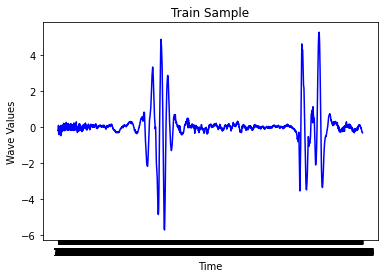

[0.19974905 0.17925394 0.14663519 ... 0.1793107  0.24080376 0.20386949]


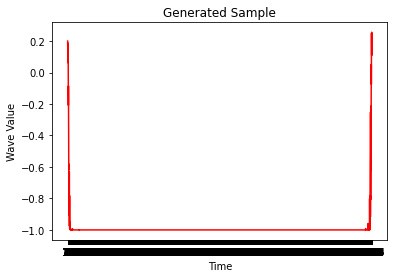

[1/100] - loss_d: 1.379, loss_g: 0.695
tensor([[-0.1559, -0.1747, -0.1322,  ..., -0.2579, -0.2087, -0.1418]],
       device='cuda:0')


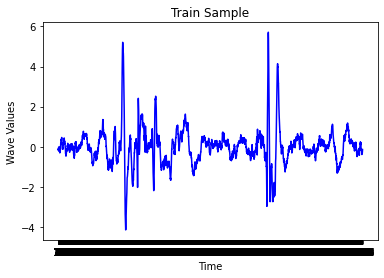

[ 0.26622587 -0.24421534 -0.25858235 ... -0.02144263  0.05381947
 -0.05254659]


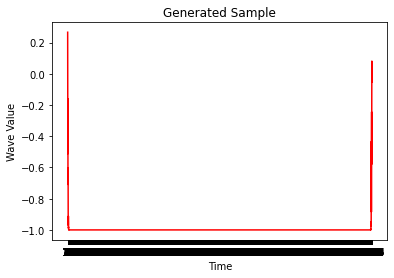

[2/100] - loss_d: 1.285, loss_g: 0.748
tensor([[-0.1382, -0.1667, -0.1697,  ...,  0.1156,  0.1364,  0.1581]],
       device='cuda:0')


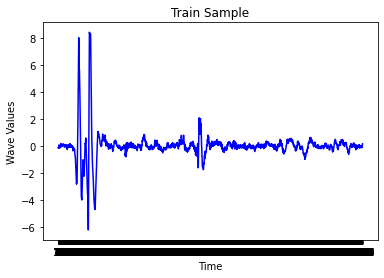

[ 0.11074072 -0.59038305  0.10303441 ... -0.2492277   0.540512
 -0.11871059]


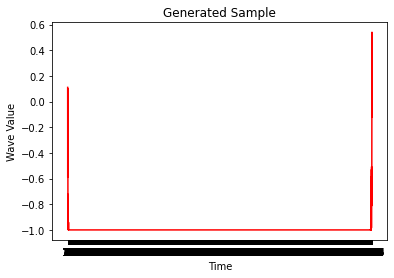

[3/100] - loss_d: 0.943, loss_g: 1.004
tensor([[ 5.1558e-02,  2.1215e-01,  4.0251e-01,  ..., -2.7337e-04,
         -1.7439e-02,  2.8468e-02]], device='cuda:0')


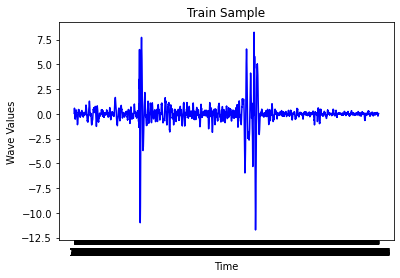

[ 0.88250995 -0.9166316   0.9420599  ... -0.3310883   0.92180216
 -0.46910876]


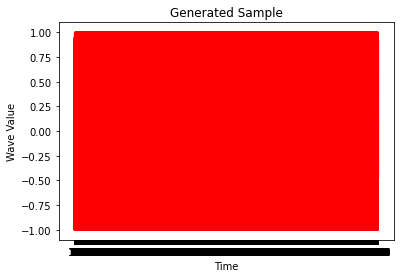

[4/100] - loss_d: 0.612, loss_g: 1.429
tensor([[0.0010, 0.0011, 0.0011,  ..., 0.0011, 0.0012, 0.0012]],
       device='cuda:0')


In [ ]:
#Training code:

gpu_boole = torch.cuda.is_available()
cnn_boole = True #set True for CNN reshaping

#TODO tune the hyper parameter carefully to achieve a nash equilibrium
#The initial hyper parameters are not ideal, you need to tune them to make things work.
k=20
epochs = 100
batch_size = 32
lr_g = 0.0001
lr_d = 0.00002
train_interval = 5

G = generator(k)
D = discriminator()
print(G)
print(D)

if gpu_boole:
    G = G.cuda()
    D = D.cuda()
    
#data loader:
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size, shuffle=True)

#D,G optimizers:
G_optimizer = optim.Adam(G.parameters(), lr=lr_g)
D_optimizer = optim.Adam(D.parameters(), lr=lr_d)
fft = Audio2Mel(n_mel_channels=k)

#loss definition(s):
BCELoss = nn.BCELoss()

#training loop:
D_losses = []
G_losses = []
print("Training start!")
for epoch in range(epochs):
    batch_number = 0
    for x_ in train_loader:
        batch_number += 1
        #reshaping depending on your architecture class:
        #if not cnn_boole:
            #x_ = x_.view(batch_size,-1) #this reshape is needed for MLP class
        if gpu_boole:
            x_ = x_
        
        x_ = x_.float().cuda()
        # print("x_: ", x_.shape)
        # x_ = fft(x_).detach().cuda()
        # print("s_", x_.shape)
            
        #Visualize the first data input
        if batch_number == 1:
          print(x_[0])
          plt.plot([i for i, _ in enumerate(x_[0].cpu().detach().numpy()[0])], x_[0].cpu().detach().numpy()[0], color="blue")
          plt.xlabel('Time')
          plt.ylabel('Wave Values')
          plt.title('Train Sample')
          plt.xticks([i for i in range(len(x_[0].cpu().detach().numpy()[0]))])
          plt.show()
        mini_batch = x_.size()[0]
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)
        if gpu_boole:
            y_real_ = y_real_.cuda()
            y_fake_ = y_fake_.cuda()
        z_ = torch.randn((mini_batch, k))
        #print("PRIOR: ", z_.shape)
        if cnn_boole:
            z_ = z_.view(-1, k, 1) #needed for CNN        
        if gpu_boole:
            z_ = z_.cuda()
            
        #print("FAKE SEEDS: ", z_.shape)
        # TODO train discriminator D
        # Step 1 get prediction of D on real data x_ and calculate D_real_loss for real data
        D_pred_real = D.forward(x_)
        #print("DISCRIMINATOR PREDICTION REAL: ", D_pred_real.shape)
        D_pred_real = torch.reshape(D_pred_real, (-1,))
        D_real_loss = BCELoss(D_pred_real, y_real_)
        
        # Step 2 get prediction of D on fake data generated by generator based on z_
        # and calculate D_fake_loss for fake data
        fake_images = G.forward(z_)
        #print(fake_images[0])
        D_pred_fake = D.forward(fake_images)
        #print("DISCRIMANTOR PREDICTION FAKE: ", D_pred_fake.shape)
        D_pred_fake = torch.reshape(D_pred_fake, (-1,))
        #print("D pred fake: ", D_pred_fake.shape)
        #print("y_fake ", y_fake_.shape)
        D_fake_loss = BCELoss(D_pred_fake, y_fake_)
        
        
        # Step 3 calculate the overall loss for D and update weight. (we've done this for you)
        D_train_loss = D_real_loss + D_fake_loss
        D.zero_grad()
        D_train_loss.backward()
        D_optimizer.step()
        D_losses.append(D_train_loss.data.item())
        
        # TODO train generator G
        # Step 0 think about the collapse problem we mentioned in lectures
        # and how we deal with that. The hyperparameter train_interval might help.
        if batch_number%train_interval!=0:
            
            # Step 1 calculate a new z_ and get prediction of fake data generated by 
            # generator based on z_
            z_ = torch.randn((mini_batch, k))
            if cnn_boole:
                z_ = z_.view(-1, k, 1) #needed for CNN        
            if gpu_boole:
                z_ = z_.cuda()
            fake_images = G.forward(z_)
            G_pred_fake = D.forward(fake_images)
            G_pred_fake = torch.reshape(G_pred_fake, (-1,))
            G_train_loss = BCELoss(G_pred_fake, y_real_)

            # Step 2 calculate the train loss for generator and update weight (we've done this for you)
            G.zero_grad()
            G_train_loss.backward()
            G_optimizer.step()

            G_losses.append(G_train_loss.data.item())
    print(fake_images[0].cpu().detach().numpy()[0])
    plt.plot([idx for idx, _ in enumerate(fake_images[0].cpu().detach().numpy()[0])], fake_images[0].cpu().detach().numpy()[0], color="red")
    plt.xlabel('Time')
    plt.ylabel('Wave Value')
    plt.title('Generated Sample')
    plt.xticks([i for i in range(len(fake_images[0].cpu().detach().numpy()[0]))])
    plt.show()
    print('[%d/%d] - loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), epochs, torch.mean(torch.FloatTensor(D_losses[-batch_size:])),
                                      torch.mean(torch.FloatTensor(G_losses[-(batch_size - batch_size // train_interval):]))))

#Plotting:

#Losses:
plt.subplot(1, 2, 1)
plt.plot(D_losses)
plt.title("D Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(G_losses)
plt.title("G Loss")
plt.xlabel("Batch number")
plt.ylabel("Loss");

In [ ]:
z_ = torch.randn((mini_batch, k))
            if cnn_boole:
                z_ = z_.view(-1, k, 1) #needed for CNN        
            if gpu_boole:
                z_ = z_.cuda()
            fake_images = G.forward(z_)


#visualize_wav(f"./drive/MyDrive/DL_FINAL_PROJECT/sample_outputs/sample_{datetime.now()}")
